# Topic modelling
We used topic modeling to find the main topics in the articles. For the purposes of topic modeling, we used LDA (Latent Dirichlet Allocation Blei, Ng and Jordan, 2003) on the bag-of-words representation of articles. There are two main assumptions of LDA that make it a great tool for topic modeling in the sense of interpretability:
1. Documents with similar topics use similar groups of words
2. Topics of documents, which are called latent topics, can be found by searching for groups of words that frequently occur together in documents across the corpus.

And we can actually think of these two assumptions mathematically: we can say that documents are probability distributions over some underlying latent topics, and then topics themselves are probability distributions over words. So LDA represents documents as mixtures of topics that spit out words with certain probabilities.

## Methodology reference
1. Text preprocessing steps were applied:
- Lower casing
- Tokenization
- Removal of stopwords from a custom list of stopwords (smart stop list)
- Removal of punctuations ??
- Removal of numbers ??
- Lemmatization

2. Word Clouds for visualization
3. LDA for topic modeling

### 1. Filtering only rows, where there was a single issue.

17871 rows as a result

In [2]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
df_single_issue

,index,issue,title,text
0,9195.0,"National Security, Defence, Foreign Affairs","""A Rare Moment of Joy"" - Sherman Statement on ...","Washington, D.C.— Today, Congressman Brad Sher..."
2,7123.0,"National Security, Defence, Foreign Affairs","""Astonishing Moral Cowardice': Sanders and Kha...",After House and Senate negotiators reached an ...
3,9173.0,"National Security, Defence, Foreign Affairs","""Finally Brought to Justice"" - Congressman She...","Washington, D.C. — Today, Congressman Brad She..."
4,9144.0,"National Security, Defence, Foreign Affairs","""I stand with the Armenian people"" - Sherman m...","Washington, D.C. — On September 19th, Congress..."
5,18774.0,"National Security, Defence, Foreign Affairs","""No"" on Proposed Continuing Resolution",Cassandra Sebastian (719) 520-0055Washington D...
...,...,...,...,...
25952,29621.0,"National Security, Defence, Foreign Affairs",“Trump’s Public Charge Rule is Cruel and Compl...,"Chicago, IL - Congressman Jesús ""Chuy"" García ..."
25953,4507.0,Federal Budget and Taxes,"“We Must Have a Tax Code Built For Growth,” We...",WASHINGTON – Speaker of the House Paul Ryan (W...
25954,8795.0,Energy and Environment,“We Need to Close the Aliso Canyon Facility No...,"Sherman Oaks, CA – On the seventh anniversary ..."
25955,4180.0,Government and Law,“We are not a dumping ground for other county’...,Rural San Bernardino County was once again tar...


In [6]:
df_single_issue.groupby("issue")["text"].count()

issue
2nd Amendment and Gun Violence                  302
Agriculture                                     723
Constitution                                     20
Disaster Relief & Preparedness                   67
Education                                      1207
Energy and Environment                         2061
Equality and Civil Rights                       514
Federal Budget and Taxes                        494
Government and Law                              940
Health Care and Social Security                2815
Housing                                         117
Infrastructure and Transportation               697
Jobs and the Economy                           1916
Local issues                                    780
National Security, Defence, Foreign Affairs    3496
Pro-Life/Abortion and Family Values             141
Science, Technology, & Telecommunications       318
Supporting Seniors                              144
Veterans and Military                          1119
Name: 

For clasterization we will use the major groups with the most data:
- National Security, Defence, Foreign Affairs                        (3496)
- Jobs and the Economy                                               (1916)
- Energy and Environment                             													   (2061)
- Health Care and Social Security                                    (2815)
- Education                                                          (1207)
- Veterans and Military                                              (1119)
- Government and Law                                                 (940)

In [14]:
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military", "Government and Law"]
df_filtered = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df_filtered.groupby("issue")["text"].count()

issue
Education                                      1207
Energy and Environment                         2061
Government and Law                              940
Health Care and Social Security                2815
Jobs and the Economy                           1916
National Security, Defence, Foreign Affairs    3496
Veterans and Military                          1119
Name: text, dtype: int64

In [17]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()


def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return stop_words

def preprocess_text(text: str, stopwords) -> str:
    
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text) # tokenization
    tokens = [lemmatizer.lemmatize(w) for w in tokens if not w.lower() in stopwords] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df_filtered["text"] = df_filtered["text"].apply(
    lambda text: preprocess_text(text, stopwords)
)
df_filtered = df_filtered[df_filtered["text"] != ""]

## 2. The most frequent words/ phrases for each issue and in general

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_phrases(doc, n=10):
    words_freq_total = []
    for n_grams in [1, 2]:
        vec = CountVectorizer(stop_words="english", ngram_range=(n_grams, 4)).fit(doc)
        bag_of_words = vec.transform(doc)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
        words_freq_total.extend(words_freq)
    return sorted(set(words_freq_total), key=lambda x: x[1], reverse=True)[:n]

In [18]:
# selected_issues = ["Agriculture, Energy and Environment", "National Security, Defence, Foreign Affairs and Veterans issues", "Education", "Health Care and Social Security", "Jobs and the Economy"]
for issue in selected_issues:
	phrases = get_top_n_phrases(df_filtered[df_filtered["issue"]==issue]["text"], n=5)
	print(issue)
	print(phrases)
	print("---")

Energy and Environment
[('water', 5909), ('energy', 3712), ('state', 3190), ('act', 2965), ('community', 2946)]
---
Education
[('student', 6096), ('school', 4852), ('education', 3349), ('program', 2477), ('college', 2131)]
---
Health Care and Social Security
[('health', 14711), ('care', 9369), ('act', 5298), ('health care', 4467), ('american', 4438)]
---
Jobs and the Economy
[('business', 3859), ('american', 3185), ('job', 2808), ('act', 2703), ('rep', 2412)]
---
National Security, Defence, Foreign Affairs
[('house', 5000), ('state', 4762), ('president', 4115), ('congressman', 4018), ('defense', 3861)]
---
Veterans and Military
[('veteran', 7289), ('service', 2130), ('va', 2053), ('act', 1498), ('house', 1409)]
---
Government and Law
[('house', 1443), ('rep', 1283), ('state', 1036), ('congressman', 949), ('act', 880)]
---


va - abbreviation for Veterans Affairs

In [19]:
get_top_n_phrases(df_filtered["text"], n=15)

[('health', 19354),
 ('act', 17818),
 ('state', 16320),
 ('house', 16123),
 ('american', 15554),
 ('rep', 15122),
 ('year', 14651),
 ('congressman', 13774),
 ('program', 13213),
 ('community', 12840),
 ('care', 12508),
 ('service', 12405),
 ('today', 12131),
 ('support', 11742),
 ('congress', 10538)]

In [20]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_cloud(df_column, max_words=20, stopwords=STOPWORDS, title=None, suptitle=None, save_name=None, show=False):
    words = " ".join(df_column.tolist())
    wordcloud = WordCloud(
        width=500,
        height=300,
        max_words=max_words,
        background_color='white',
        stopwords=stopwords,
        random_state=42,
        collocation_threshold=10,
    ).generate(words)
    plt.figure(figsize=(10, 6), facecolor=None)
    plt.title(title)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    if save_name is not None:
        plt.savefig(save_name)
    if show is True:
        plt.show()

Energy and Environment
[('water', 5909), ('energy', 3712), ('state', 3190), ('act', 2965), ('community', 2946)]


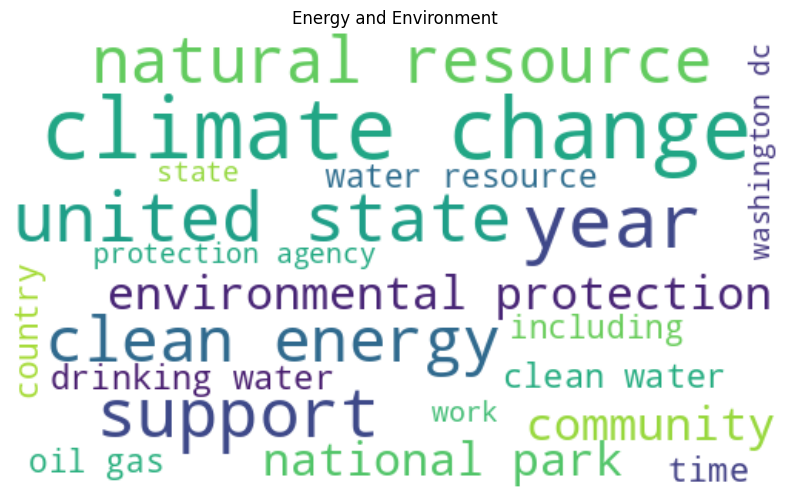

---
Education
[('student', 6096), ('school', 4852), ('education', 3349), ('program', 2477), ('college', 2131)]


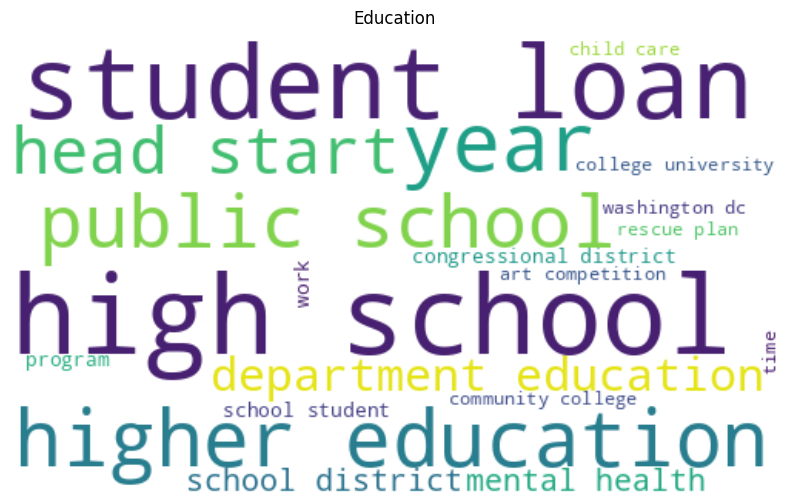

---
Health Care and Social Security
[('health', 14711), ('care', 9369), ('act', 5298), ('health care', 4467), ('american', 4438)]


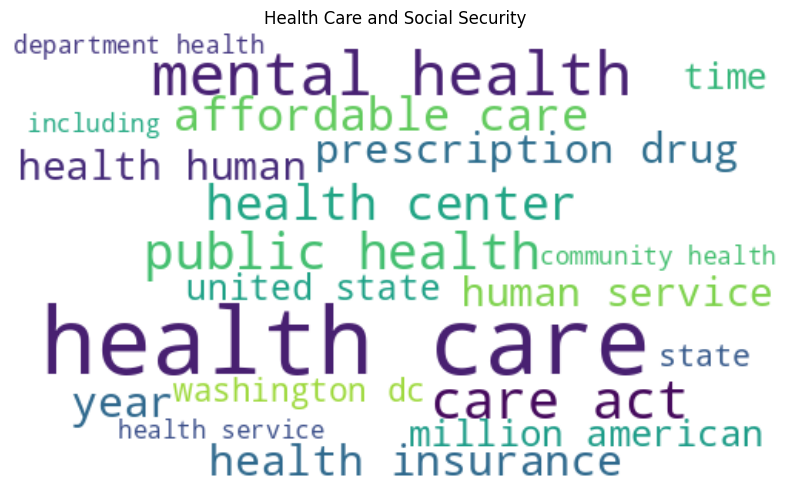

---
Jobs and the Economy
[('business', 3859), ('american', 3185), ('job', 2808), ('act', 2703), ('rep', 2412)]


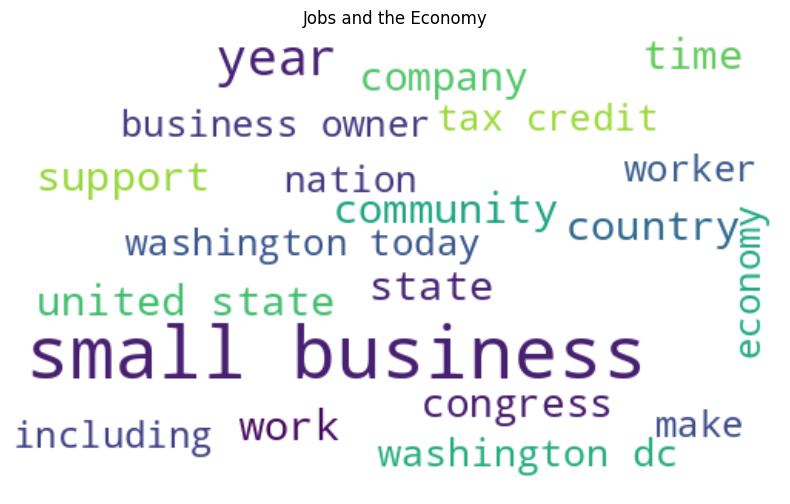

---
National Security, Defence, Foreign Affairs
[('house', 5000), ('state', 4762), ('president', 4115), ('congressman', 4018), ('defense', 3861)]


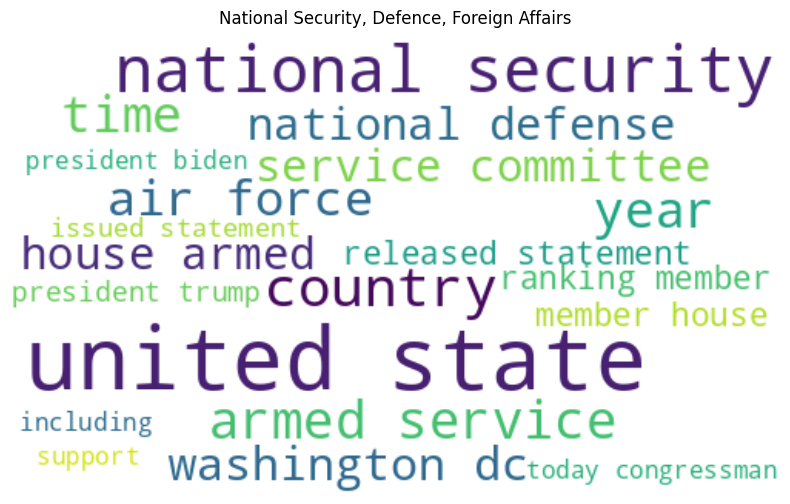

---
Veterans and Military
[('veteran', 7289), ('service', 2130), ('va', 2053), ('act', 1498), ('house', 1409)]


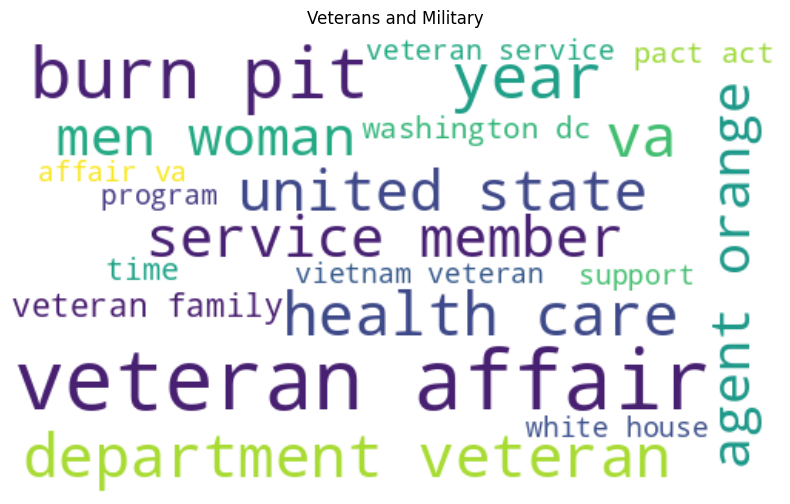

---
Government and Law
[('house', 1443), ('rep', 1283), ('state', 1036), ('congressman', 949), ('act', 880)]


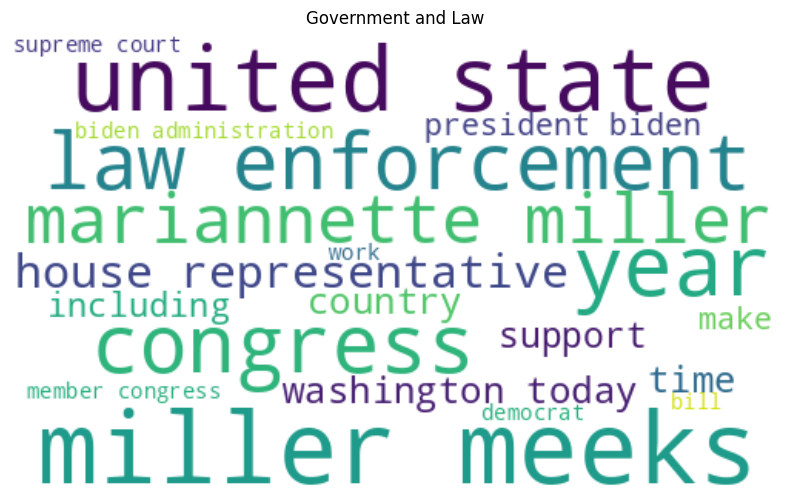

---


In [21]:
for issue in selected_issues:
	phrases = get_top_n_phrases(df_filtered[df_filtered["issue"]==issue]["text"], n=5)
	print(issue)
	print(phrases)
	issue_name = issue.replace(" ", "").replace(",", "")
	show_cloud(df_filtered[df_filtered["issue"]==issue]["text"], max_words=20, show=True, title=issue, save_name=f"word_clouds/word_cloud_{issue_name}.png")
	print("---")


## LDA

In [22]:
#LDA modeling
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

def lda_preproc(df_column):
    words = [sentence.split(" ") for sentence in df_column.tolist()]
    id2word = corpora.Dictionary(words)
    corpus = [id2word.doc2bow(text) for text in words]
    id2word.filter_extremes(no_below=0.1, no_above=0.7)
    return corpus, id2word

def lda_plot_results(corpus, id2word=None, num_topics=10, save_name=None, iterations=50, alpha='asymmetric'):
    lda = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=num_topics,
                   random_state=42,
                   iterations=iterations,
                   passes=5,
                   alpha=alpha,
                   per_word_topics=False)
    lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, id2word, sort_topics=False)
    if save_name is not None:
        pyLDAvis.save_html(lda_display, save_name+'.html')
    pyLDAvis.display(lda_display)
    return pyLDAvis.display(lda_display), lda

In [23]:
# selected_issues = ["Agriculture, Energy and Environment", "National Security, Defence, Foreign Affairs and Veterans issues", "Jobs and the Economy"]
corpus, id2word = lda_preproc(df_filtered[df_filtered['issue'].isin(selected_issues)]["text"])
# corpus, id2word = lda_preproc(df_filtered["text"])
vis, lda = lda_plot_results(corpus=corpus, id2word=id2word, num_topics=6, save_name='LDA_results_top_3')
vis